# California Housing Prices

---
Hands-On Machine Learning with Scikit-Learn and TensorFlow

## 1. Downloading the Data

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing/"
FILE_NAME = "housing.tgz"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + FILE_NAME

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH, file_name = FILE_NAME):
    # creating directory for our dataset
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    # downloading data
    tgz_path = housing_path + file_name
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

In [6]:
def load_housing_data(housing_path = HOUSING_PATH, ):
    csv_path = housing_path + 'housing.csv'
    return pd.read_csv(csv_path)

## 2. Take a Quick Look at the Data Structure

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<b>NOTE:</b> Right awey we see that all attributes are numerical, except the ocean_proximity field. ocean_proximity is categorical attribute. Let's check what categories exist and how many districts belong to each category.

In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


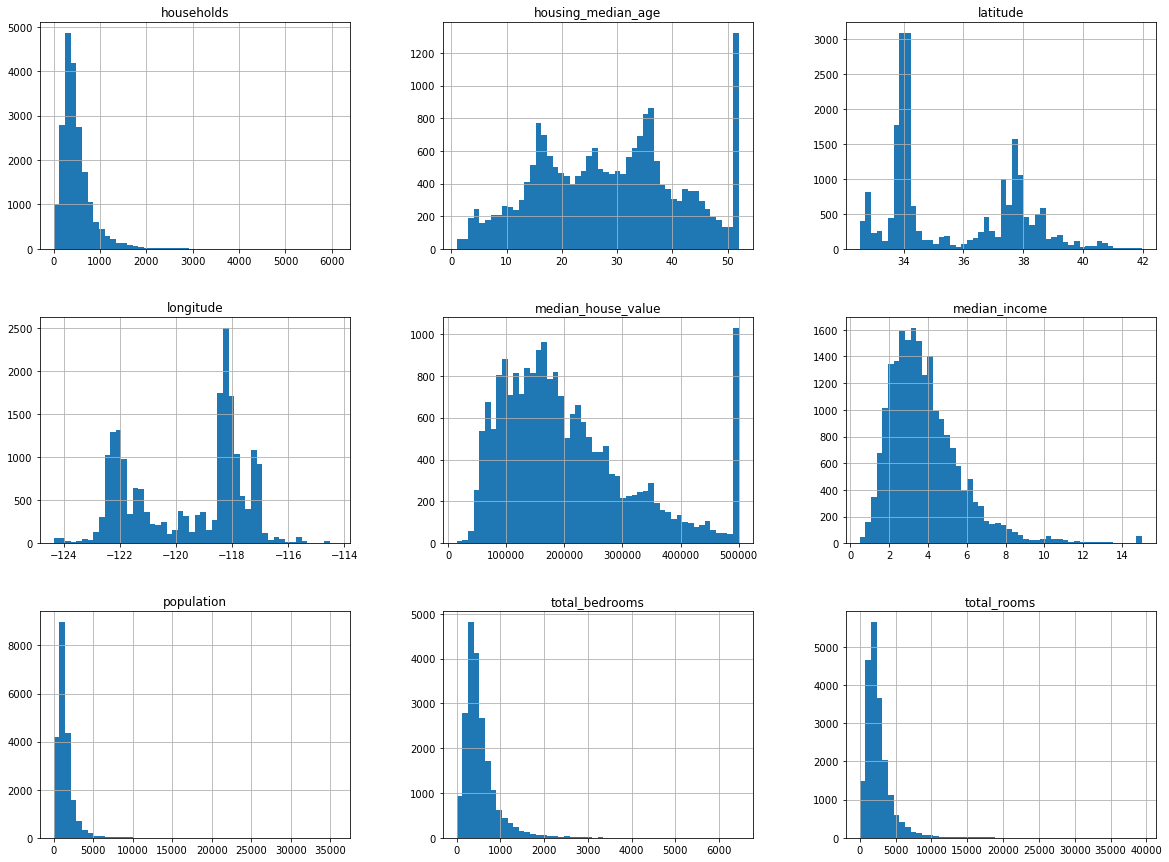

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## 3. Creaate a Test Set

In [12]:
import numpy as np
np.random.seed(42)

def split_train_tes(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_tes(housing, 0.2)

In [14]:
print(len(train_set), "train + ", len(test_set), "test")

16512 train +  4128 test


<b>NOTE:</b> Using np.random.seed(42) will guarantee identical split of dataset each time, provided that size of dataset will not change. Unfortunately it will break if you fetch updated dataet. A common solution is to compute a hash of each instance's identifier and assign instance to tast or train set basing on value of last byte.

In [59]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    # function return True/False values
    # it chechs if value of last byte is smaller then 256 * test_ratio, because we can store 256 unique values in byte
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [62]:
housing_with_id = housing.reset_index() #adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

<b>NOTE:</b> We cen also use one of functions provided by Scikit-Learn:

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<b>NOTE:</b> To avoid bias we can also use stratified sampling. Firstly we need to add new categorical column based on incom.

In [68]:
#numpy cail return cailing of input value
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [69]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


<b>NOTE:</b> Now we are ready to do stratified sampling. For this we can use StratifiedShuffleSplit class.

In [73]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_test_set = housing.loc[test_index]
    strat_train_set = housing.loc[train_index]

In [74]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [76]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

<b>NOTE:</b> Now we should remove the income_cat attribute.

In [77]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3. Discover and Visualize the Data to Gain Insights

In [78]:
housing = strat_train_set.copy()

### 3.1. Visualizing Geographical Data

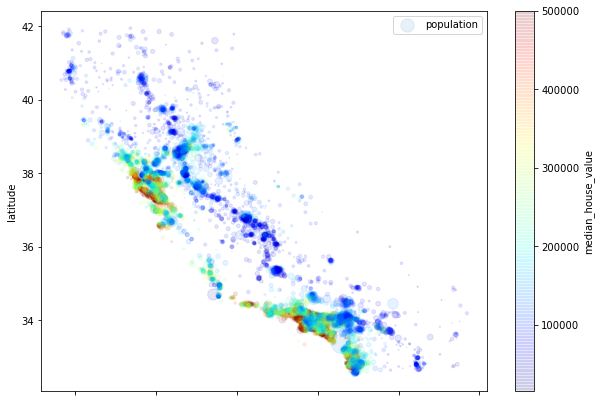

In [87]:
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4, 
    figsize =(14, 10), 
    s=housing["population"]/100, 
    label="population", 
    c="median_house_value", 
    cmap=plt.get_cmap("jet"), 
    colorbar=True
)
plt.legend()